Iván Ricardo Paredes Avilez 
A01705083

19/11/2023

Evidencia 1. Actividad Integradora

Modelo de robots y almacenamiento de cajas.

Descripción de la estrategia y mecanismos utilizados:

Tenemos dos clases. La clase RobotAgent representa a cada robot en el modelo. Cada agente tiene una identificación única, una posición en la cuadrícula, una caja actual que lleva consigo, un destino objetivo para la caja y una matriz para almacenar las posiciones de las cajas en el entorno. Por otra parte, el entorno se modela utilizando la clase StorageModel, que contiene una cuadrícula bidimensional para representar la distribución de cajas y un conjunto de agentes que interactúan en este entorno.

Para la inicialización, se ubica la distribución de cajas en posiciones aleatorias dentro de la cuadrícula, asegurándose de que no haya más de tres cajas en una ubicación inicial. Los agentes se colocan en posiciones aleatorias sin cajas. Después, para la interacción de los robots se tiene el método step de la clase RobotAgent. Con este, los agentes intentan recoger una caja de las celdas vecinas si está disponible. Se verifica si el agente ya lleva una caja y si la caja en la celda vecina tiene un valor menor que 5 antes de recogerla. Los agentes se mueven a posiciones aleatorias que no tienen cajas, evitando colisiones con otras cajas o agentes. 

En cuanto a la organización de cajas, el método check_box_distribution verifica si la distribución de cajas en la cuadrícula es equilibrada, es decir, si todas las cajas están distribuidas en múltiplos de 5. Si no es así, se activa el método reorganize_boxes. También, el método reorganize_boxes selecciona aleatoriamente a un agente que no lleva una caja y lo mueve a una celda vecina sin una caja, contribuyendo así a equilibrar la distribución de cajas.

Por la parte del modelo, este se ejecuta durante un número específico de pasos (STEPS). En cada paso, se recopilan datos utilizando el DataCollector. Se realiza una verificación del equilibrio de cajas y, si es necesario, se reorganizan las cajas antes de que los agentes realicen sus movimientos. Al final de la simulación, se imprime el número de pasos utilizados y se visualiza la distribución final de las cajas en la cuadrícula utilizando matplotlib.


¿Existe una forma de reducir el número de pasos utilizados? Si es así, ¿cuál es la estrategia que se tendría en implementar?

Ya que actualmente se realiza una búsqueda aleatoria para encontrar las cajas, tal vez una aproximación diferente para esto sería que en lugar de realizar una búsqueda aleatoria, se almacenar las posiciones válidas en el agente y luego elegir entre esas posiciones durante el movimiento.

In [279]:
# Importación de módulos de la biblioteca Mesa para modelado basado en agentes
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

# Importación de bibliotecas estándar de Python para operaciones numéricas, generación de números aleatorios y visualización
import numpy as np
import random
import matplotlib.pyplot as plt

In [280]:
class RobotAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.id = id
        self.box = ()  # Caja actual que lleva el agente
        self.target = ()  # Destino objetivo para la caja
        self.box_position = np.zeros((model.grid.width, model.grid.height), dtype=int)  # Matriz para almacenar posiciones de cajas

    def step(self):
        position = ()
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)

        # Recoger una caja si está disponible en las celdas vecinas
        for i in possible_steps:
            (x, y) = i
            if self.model.boxes[x][y] > 0:
                self.box_position[x][y] = self.model.boxes[x][y]
                if len(self.box) > 0 and self.model.boxes[x][y] < 5:
                    self.box = ()
                    self.model.boxes[x][y] += 1
                    self.box_position[x][y] += 1
                    self.model.pickedup_boxes -= 1

        # Moverse a una posición aleatoria que no tenga una caja
        position = random.choice(possible_steps)
        while self.model.boxes[position] > 0 or self.box_position[position] > 0:
            position = random.choice(possible_steps)

        # Mover al agente a la posición seleccionada
        self.model.grid.move_agent(self, position)
        self.pos = position

In [281]:
class StorageModel(Model):
    def __init__(self, width, height, num_agents, boxes):
        self.schedule = SimultaneousActivation(self)
        self.grid = MultiGrid(width, height, torus=False)
        self.boxes = np.zeros((width, height), dtype=int)  # Matriz para representar la distribución de cajas en el entorno
        self.pickedup_boxes = 0  # Contador de cajas recogidas por los agentes
        self.datacollector = DataCollector(model_reporters={"Robots": getRobots, "Boxes": getBoxes})
        
        # Inicializar cajas en posiciones aleatorias
        initial_boxes = 0
        while initial_boxes < boxes:
            x, y = np.random.randint(0, width), np.random.randint(0, height)
            if self.boxes[x, y] < 3:
                self.boxes[x, y] += 1
                initial_boxes += 1

        # Inicializar agentes en posiciones aleatorias sin cajas
        agent_positions = []
        while len(agent_positions) < num_agents:
            x, y = np.random.randint(0, width), np.random.randint(0, height)
            if (x, y) not in agent_positions and self.boxes[x, y] == 0:
                agent = RobotAgent(len(agent_positions), self)
                self.schedule.add(agent)
                self.grid.place_agent(agent, (x, y))
                agent_positions.append((x, y))

    def step(self):
        self.datacollector.collect(self)

        # Verificar si la distribución de cajas está equilibrada
        if not self.check_box_distribution():
            self.reorganize_boxes()

        # Mover agentes y ejecutar sus pasos
        self.schedule.step()

    def check_box_distribution(self):
        return np.all(self.boxes % 5 == 0)  # Verificar si todas las cajas están distribuidas en múltiplos de 5

    def reorganize_boxes(self):
        # Mover un agente a una celda vecina sin una caja
        for agent in self.schedule.agents:
            if len(agent.box) == 0:
                possible_steps = self.grid.get_neighborhood(agent.pos, moore=False, include_center=False)
                for step in possible_steps:
                    x, y = step
                    if self.boxes[x][y] < 5:
                        self.grid.move_agent(agent, step)
                        agent.pos = step
                        return

In [282]:
#Funciones auxiliares
def getRobots(model):
    return np.asarray([agent.pos for agent in model.schedule.agents])

def getBoxes(model):
    return model.boxes

El número de pasos usados en la simulación fue:  1000


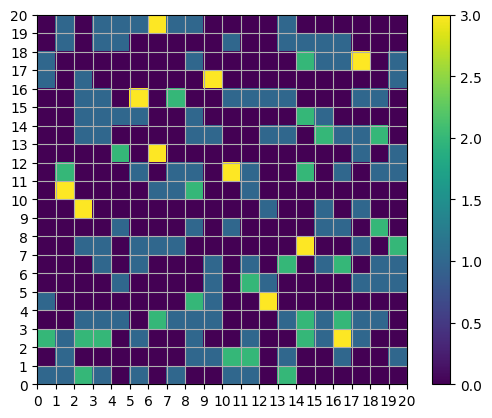

In [283]:
# Parámetros del modelo
WIDTH = 20
HEIGHT = 20
NUM_AGENTS = 5
STEPS = 1000
BOXES = 200
SEED = 67890
random.seed(SEED)

# Crear y ejecutar el modelo
model = StorageModel(WIDTH, HEIGHT, NUM_AGENTS, BOXES)

for i in range(STEPS):
    model.step()

# Imprimir el número de pasos
print("El número de pasos usados en la simulación fue: ", STEPS)

# Visualizar la distribución final de cajas usando matplotlib
final_box_distribution = model.datacollector.get_model_vars_dataframe()["Boxes"].iloc[-1]

cmap = plt.cm.viridis  # Cambiar el color a 'viridis'

plt.imshow(final_box_distribution, cmap=cmap, interpolation='nearest', origin='lower', extent=[0, WIDTH, 0, HEIGHT])
plt.colorbar()
plt.xticks(np.arange(0, HEIGHT+1, 1))
plt.yticks(np.arange(0, WIDTH+1, 1))
plt.grid(True)
plt.show()